# 딥러닝을 활용한 상품 판매량 예측

## 프로젝트 개요

- 본 프로그램은 상품 판매 데이터를 활용해 예측 모델을 훈련하고 단기 미래 판매량을 예측하는 내용입니다.
- 모델 훈련을 위해 사용하는 데이터는 단일 변수인 sales 값이며, 날짜 단위로 제공되는 sales값을 이용해 모델을 훈련하고 미래의 sales 값을 예측합니다.
- 이 사례는 단일 변수인 sales 값이 x 값인 동시에 예측해야하는 y값이므로 이와 유사하게 단일 변수 환경의 시계열 데이터를 분석하는 판매량 예측, 주가 종가 예측, 수요 예측 등에 적용해 볼 수 있습니다.
- 본문에서 사용하는 판매 데이터는 kaggle에 공개된 drug store 데이터를 활용하며, 데이터의 기간이 길지 않아 시즌에 따른 주기성 등을 정확히 반영하지 못하며 최근 몇 일의 데이터를 활용해 미래 하루를 예측하고 있음을 이해해 주기 바랍니다. 다양한 변수를 고려한 보다 정확한 예측 모델을 고려하는 경우에는 Multi-variable을 사용하는 모델을 이용해 보기를 권한다.

## 데이터 개요

- 데이터는 kaggle에 공개된 독일 Drug Store 계열 판매점인 Rossmann의 데이터를 사용하였다.
- 데이터 크기를 줄이기 위해 rossmann_train.csv 파일에서 store 1번과 필요한 컬럼만 필터링하고 제품정보가 없기 때문에 전체를 하나의 제품으로 보기 위해 product_c를 0으로 지정하여 rossmann_simple.csv 파일로 저장하였다.
- 원본 데이터 링크 : https://www.kaggle.com/c/rossmann-store-sales

## 데이터 분석 개요

- **일별로 제공되는 단일변수 시계열 데이터**를 활용하 미래를 예측한다.
- **5일치 과거 데이터를 활용해 1일치 미래가격을 예측**한다.
- 일별로 제공되는 상품별 판매 수량 데이터로 일별 상품 판매량을 예측한다.
- 판매량 단일 변수로 미래를 예측하는 과제 이므로 변수들 간 correlation 분석이나 feature 가중치 분석등 feature engineering이 불가한 경우이므로 
- 데이터 종류
    - **Rossmann** (독일의 Drug Store)에서의 상품 판매량 데이터를 기반으로 판매량 예측 모델을 구현한다.
    - 1개 store, 통합 판매량 942건 (2013.01.01 ~ 2015.07.31)
- 데이터는 min/max scaler를 이용해 주문량을 -1 ~ +1로 스케일링하여 훈련 및 테스트 하고 결과를 다시 원래 스케일로 복원한다.
- train을 수행하면 runs 폴더 아래 각 product 별로 online 제품 주문을 예측하는 모델 파일이 생성된다.
- inference를 수행하면 train에서 생성된 모델 중에서 해당하는 product의 model 파일을 읽어오고 5일치 데이터를 입력하면 다음날의 주문량을 예측한다.

## 운영 및 개발 환경



### 주요 라이브러리 정보

- python : 3.7.9
- tensorflow : 2.0.0
- numpy : 1.19.3
- scipy : 1.5.4
- scikit-learn : 0.24.0
- pandas : 1.1.5
- matplotlib : 3.3.3

## 데이터 특성

**data/raw/rossmann_simple.csv**
- kaggle(https://www.kaggle.com/c/rossmann-store-sales)에서 제공하는 공개 데이터
- 일자별 전체 상품 판매량 데이터
- 원본 데이터에서 제품 정보를 제공하지 않아 전체 상품의 판매를 예측하는 것으로 진행하였음
- 원본 rossmann_train.csv 파일은 약 38MB이며 이 중에서 Store = 1번만 추출하여 rossmann_simple.csv 파일 생성
- rossmann_train.csv : kaggle에서 다운로드 받은 원본 데이터 파일
  - store (int) : 매장 ID
  - DayOfWeek (1~7) : 요일
  - Date (YYYY.mm.dd) : 일자
  - Sales (int) : 판매량
  - Customer (int) : 고객 ID
  - Open (0 or 1) : 매장 Open 여부
  - Promotion (0 or 1): 프로모션 여부
  - StateHoliday (0, a, b, c) : 휴일 종류
  - SchoolHoliday (0 or 1) : 학교 휴일 여부
- rossmann_simple.csv
  - store (int) : 매장 ID, 전부 1
  - date (YYYY-mm-dd) : 일자
  - Sales (int) : 판매량

## 모듈 import 및 초기 환경 설정

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from matplotlib.dates import WeekdayLocator, MonthLocator, YearLocator
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'data')
MODEL_DIR = os.path.join(ROOT_DIR, 'run', 'model')
PROCESS_DIR = os.path.join(os.path.dirname(ROOT_DIR), 'data', 'processed')

print(ROOT_DIR)
print(DATA_DIR)

folder_path = DATA_DIR
data_raw_dir = os.path.join(folder_path, 'raw')
data_processed_dir = os.path.join(folder_path, 'processed')

os.makedirs(data_raw_dir, exist_ok=True)
os.makedirs(data_processed_dir, exist_ok=True)

train_file_path = os.path.join(data_raw_dir, 'train.csv')
test_file_path = os.path.join(data_raw_dir, 'test.csv')

print('train file path:', train_file_path)
print('test file path:', test_file_path)

/Users/machangsu/Documents/dev/skcc-accuinsight-examples/applying_machine_learning/store_sales_prediction
/Users/machangsu/Documents/dev/skcc-accuinsight-examples/applying_machine_learning/store_sales_prediction/data
train file path: /Users/machangsu/Documents/dev/skcc-accuinsight-examples/applying_machine_learning/store_sales_prediction/data/raw/train.csv
test file path: /Users/machangsu/Documents/dev/skcc-accuinsight-examples/applying_machine_learning/store_sales_prediction/data/raw/test.csv


## 모델 관련 환경변수 설정

In [2]:
# 모델 훈련 및 예측에 사용할 데이터의 기간(일)
WINDOW_SIZE = 5

# 예측할 미래 예측 기간(일)
OUTPUT_PREDICT_DAYS = 1

# 모델 훈련에 사용할 최소한의 기간
DATA_MINIMUM_PERIOD = 20

# LSTM 레이어 계층의 수
LSTM_LAYER_NUM = 1

# LSTM Layer 1층에 포함되는 Unit 의 수
LSTM_UNIT_NUM = 128

# 학습율
LEARNING_RATE = 0.01
# Total Epoch 수 / product
NUM_EPOCH = 50

# Batch Size
BATCH_SIZE = 10

# Drop Out Rate
DROPOUT_RATE = 0.5

# 데이터 수집 및 이해

- 데이터는 kaggle(https://www.kaggle.com/c/rossmann-store-sales)에서 제공하는 공개 데이터를 다운로드하여 사용하였다.
- 모델 훈련에는 train.csv 파일을 사용하였고, 평가에는 test.csv 파일을 사용사였다.

# 데이터 탐색 및 정재

(데이터 성향 파악, 통계 분석, 히스토그램 분석, 시각화 분석, 데이터 정제)

In [3]:
train_data = pd.read_csv(train_file_path, index_col=1)
train_data = train_data[train_data['Store'] == 1]
train_data = train_data[['Store', 'Date', 'Sales']]
train_data.rename(columns={'Store':'store', 'Date':'date', 'Sales':'sales'}, inplace=True)
train_data.sort_values(by='date', inplace=True)
train_data.reset_index(drop=True, inplace=True)

train_data.describe()

,store,sales
count,942.0,942.000000
mean,1.0,3945.704883
std,0.0,2015.417840
min,1.0,0.000000
25%,1.0,3588.250000
50%,1.0,4373.500000
75%,1.0,5220.000000
max,1.0,9528.000000


In [5]:
sales_train_data = train_data

In [51]:
# 데이터를 확인해보면 매주 일요일에 해당하는 sales 데이터가 모두 0임을 알 수 있다.
# 해당 항목을 포함하여 예측을 하게되면 전체값을 수렴시키기 어려운 문제가 있어 일요일 데이터를 제거하고 예측하도록 한다.
# rossmann 데이터에는 제품 정보가 없다. 따라서 전체가 동일한 제품이라고 가정하고 임의의 제품 코드 정보를 입력한다.

sales_train_data['product_c'] = 0

sales_train_data[:10]

,store,date,sales,product_c
0,1,2013-01-01,4600.066832,0
1,1,2013-01-02,5530.000000,0
2,1,2013-01-03,4327.000000,0
3,1,2013-01-04,4486.000000,0
4,1,2013-01-05,4997.000000,0
6,1,2013-01-07,7176.000000,0
7,1,2013-01-08,5580.000000,0
8,1,2013-01-09,5471.000000,0
9,1,2013-01-10,4892.000000,0
10,1,2013-01-11,4881.000000,0


In [7]:
# 아래는 일요일에 해당하는 row를 삭제하는 코드이다. 이 코드는 rossmann 데이터에만 해당하는 옵션이므로 필요없는 경우 제거해도 된다.
sales_train_data = sales_train_data[pd.to_datetime(sales_train_data['date']).dt.dayofweek != 6]
sales_train_data[:14]

,store,date,sales,product_c
0,1,2013-01-01,0,0
1,1,2013-01-02,5530,0
2,1,2013-01-03,4327,0
3,1,2013-01-04,4486,0
4,1,2013-01-05,4997,0
6,1,2013-01-07,7176,0
7,1,2013-01-08,5580,0
8,1,2013-01-09,5471,0
9,1,2013-01-10,4892,0
10,1,2013-01-11,4881,0


In [8]:
print('Store 갯수:', len(sales_train_data['store'].unique()))
print('전체 항목 갯수:', sales_train_data.groupby('store')['date'].count())

Store 갯수: 1
전체 항목 갯수: store
1    808
Name: date, dtype: int64


In [9]:
# store 별로 모델을 별도로 훈련시켜야 한다.
# 우리는 우선 그중 한 개의 Store만 지정해서 진행하려고 한다.

select_store_id = 1  # 많은 store 중에서 1번만 선택하여 진행하기 위해 선택한다.
sales_train_data = sales_train_data[sales_train_data['store'] == select_store_id]
sales_train_data['date'] = pd.to_datetime(sales_train_data.date, format='%Y-%m-%d')
sales_train_data.describe()

,store,sales,product_c
count,808.0,808.000000,808.0
mean,1.0,4600.066832,0.0
std,0.0,1312.455160,0.0
min,1.0,0.000000,0.0
25%,1.0,3936.000000,0.0
50%,1.0,4601.500000,0.0
75%,1.0,5326.500000,0.0
max,1.0,9528.000000,0.0


(array([27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         1.,  1.,  2., 12., 22., 41., 58., 58., 67., 47., 51., 66., 51.,
        48., 54., 48., 38., 26., 16., 18., 12.,  6.,  8.,  3.,  6.,  4.,
         2.,  3.,  3.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([   0.  ,  190.56,  381.12,  571.68,  762.24,  952.8 , 1143.36,
        1333.92, 1524.48, 1715.04, 1905.6 , 2096.16, 2286.72, 2477.28,
        2667.84, 2858.4 , 3048.96, 3239.52, 3430.08, 3620.64, 3811.2 ,
        4001.76, 4192.32, 4382.88, 4573.44, 4764.  , 4954.56, 5145.12,
        5335.68, 5526.24, 5716.8 , 5907.36, 6097.92, 6288.48, 6479.04,
        6669.6 , 6860.16, 7050.72, 7241.28, 7431.84, 7622.4 , 7812.96,
        8003.52, 8194.08, 8384.64, 8575.2 , 8765.76, 8956.32, 9146.88,
        9337.44, 9528.  ]),
 <BarContainer object of 50 artists>)

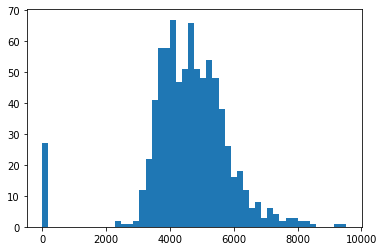

In [10]:
# sales에 대한 빈도를 확인하면 4000~5000 사이가 가장 많고, 0인 값도 150(전체 중 약 20%) 정도나 된다.
plt.hist(sales_train_data['sales'], bins=50)

<AxesSubplot:title={'center':'Daily Sales'}>

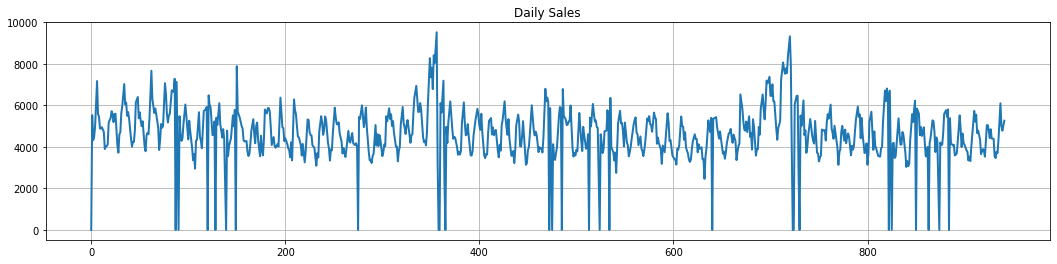

In [11]:
# 일자별 값을 선형 차트로 표시해보면 약 3,000 ~ 9,000 사이의 범위에 대부분의 값이 위치하는 것을 알수 있다.
plt.rcParams["figure.figsize"] = (18,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True
plt.title('Daily Sales')
sales_train_data['sales'].plot()

In [12]:
sales_train_data.loc[sales_train_data['sales'] == 0, 'sales'] = sales_train_data['sales'].mean()

<AxesSubplot:>

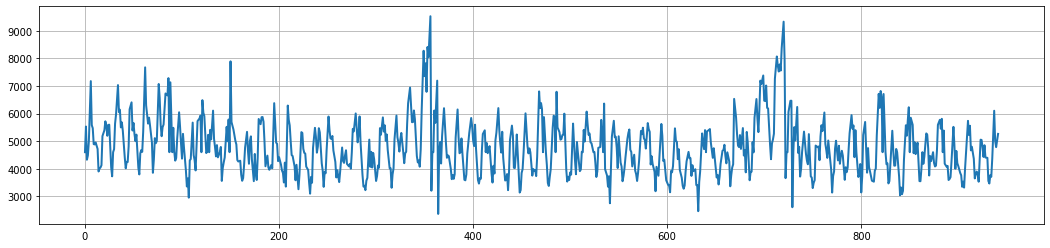

In [13]:
sales_train_data['sales'].plot()

In [52]:
def product_data_prepare(data_all):
    """ 전체 데이터를 이용해 product에 대해 날짜별 데이터 집계를 한다."""

    # Modified
    product_dates = data_all.groupby(
        ['product_c']
    ).agg(
        {'date': [np.min, np.max]}
    ).reset_index(level='product_c')

    product_dates.columns = list(map('_'.join, product_dates.columns.values))
    product_dates.rename(columns={'date_amin': 'date_min', 'date_amax': 'date_max'}, inplace=True)
    product_dates['duration'] = pd.to_datetime(product_dates['date_max']) - pd.to_datetime(product_dates['date_min'])
    product_dates['duration'] = product_dates['duration'].dt.days
    return product_dates

In [15]:
# rossmann은 온라인 이기 때문에 store가 1개이다.
# 기간을 확인해보니 2013년 1월 ~ 2015년 7월까지 31개월의 데이터이다.
sales_product_period = product_data_prepare(sales_train_data)
sales_product_period

,product_c_,date_min,date_max,duration
0,0,2013-01-01,2015-07-31,941


In [16]:
sales_product_list = list(sales_product_period['product_c_'].astype(int))

# 모델은 store x product에 대해 별도로 생성하는데 그 중에서 첫 번째 product만 선택해서 모델을 훈련하고 테스트 해 보려고 한다.
# rossmann 데이터는 product 정보가 없어서 모두 0값을 갖고 있어서 여차피 1개 밖에 없기는 하다.
target_product_code = sales_product_list[0]

In [17]:
# train data의 시작 날짜, 종료 날짜
train_start_date = sales_product_period.loc[sales_product_period.product_c_ == target_product_code, ['date_min']].values[0][0]
train_end_date = sales_product_period.loc[sales_product_period.product_c_ == target_product_code, ['date_max']].values[0][0]

train_start_date, train_end_date

(numpy.datetime64('2013-01-01T00:00:00.000000000'),
 numpy.datetime64('2015-07-31T00:00:00.000000000'))

**Sales Data를 적재하고 정제하는 클래스**

In [18]:
class SalesData():

    fillna_func_nan = 0
    fillna_func_zero = 1
    fillna_func_mean = 2
    fillna_func_prev = 3

    def __init__(
            self,
            data_set,
            start_date,
            end_date,
            test_days,
            target_product,
            fillna_func=fillna_func_zero
    ):
        self.data_set = data_set
        self.start_date = start_date
        self.end_date = end_date
        self.test_days = test_days
        self.target_product = target_product
        self.fillna_func =  fillna_func

        self.df = self.target_data()
        self.df_train, self.df_test, self.scaler_y = self.df_scale()

    def target_data(self):
        data_target = self.data_set.loc[
            (self.data_set.product_c == self.target_product)
        ]

        df = pd.DataFrame({'date': pd.date_range(start=self.start_date, end=self.end_date)})
        df['date'] = pd.to_datetime(df['date']).dt.date
        data_target.date = pd.to_datetime(data_target['date']).dt.date
        merged_sales = pd.merge(df, data_target, how='left', on='date')
        merged_sales["product_c"] = self.target_product

        ######################################################################
        # 비어 있는 날짜에 해당하는 값 채우기
        # [1] 0값으로 채운다. (default)
        # [2] 평균 값으로 채운다.
        # [3] 이전 값으로 체운다.
        # [4] 채우지 않는다.
        if self.fillna_func == self.fillna_func_zero:
            merged_sales = merged_sales.fillna(0)
        elif self.fillna_func == self.fillna_func_mean:
            merged_sales = merged_sales.fillna(data_target.sales.mean())
        elif self.fillna_func == self.fillna_func_prev:
            merged_sales = merged_sales.fillna(method='ffill')

        return merged_sales

    def df_scale(self):
        """ 데이터를 train(마지막 5개를 제외한 데이터) / test(마지막 5개 데이터) 데이터로 나누고
        ±1값을 갖도록 데이터를 기준으로 scale 하여 scaler와 함께 반환한다. """

        df = self.df

        def scale_and_transform(data):
            data_ = np.array(data)
            data_scaler = MinMaxScaler(feature_range=(-1, 1))
            data_scaler.fit(data_.reshape((-1, 1)))
            data_ = data_scaler.transform(data_.reshape((-1, 1)))
            data_ = data_.reshape(-1)
            return data_, data_scaler

        y_, scaler_y = scale_and_transform(df.sales)

        train_test_index = len(y_) - self.test_days
        train = [
            y_[0:train_test_index],
        ]
        test = [
            y_[train_test_index:],
        ]

        df_train = pd.DataFrame(data=train).transpose()
        df_train.columns = ['sales']

        df_test = pd.DataFrame(data=test).transpose()
        df_test.columns = ['sales']

        # df_train=> (725, 1), df_test=>(5, 1), scaler_y => 복원을 위한 min/max scaler
        return df_train, df_test, scaler_y

In [19]:
a_sale = SalesData(
    data_set=sales_train_data,
    start_date=train_start_date,
    end_date=train_end_date,
    test_days=WINDOW_SIZE,
    target_product=target_product_code,
    fillna_func=SalesData.fillna_func_prev  # 이전 날짜의 값으로 빈 값을 채운다.
)
print('<Train Data>\n', a_sale.df_train.describe())
print('<Test Data>\n', a_sale.df_test.describe())
a_sale.df_train[:14]

<Train Data>
             sales
count  937.000000
mean    -0.325630
std      0.273568
min     -1.000000
25%     -0.528049
50%     -0.368685
75%     -0.172760
max      1.000000
<Test Data>
           sales
count  5.000000
mean  -0.197991
std    0.143272
min   -0.324588
25%   -0.260675
50%   -0.258164
75%   -0.190343
max    0.043818


,sales
0,-0.375365
1,-0.115825
2,-0.451577
3,-0.407201
4,-0.264583
5,-0.264583
6,0.343567
7,-0.101870
8,-0.132291
9,-0.293888


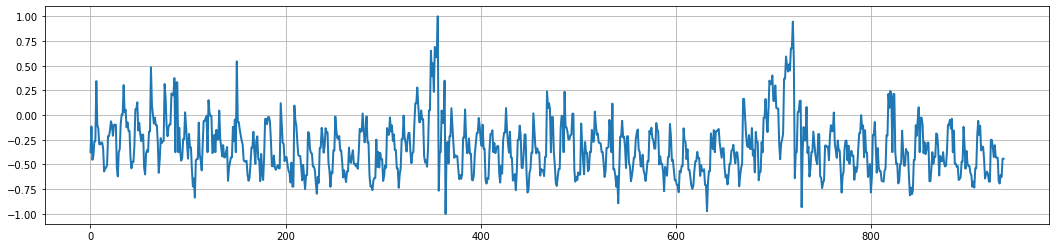

In [20]:
plt.plot(a_sale.df_train)

# 데이터 분리 및 모델 준비

**아래에서 Rossmann 데이터, OliveYoung 데이터, Kaggle의 mock 데이터 중 사용할 데이터를 선택해 a_sales 변수에 할당하면 모델 훈련 및 테스트에 사용한다. 원하는 라인만 주식을 제거하고 실행하면 된다..**

**훈련 및 평가 데이터 준비**

* 훈련 데이터와 평가 데이터를 분리하고 (number of row, windows size, feature num) 형식의 데이터를 생성하여 준비한다.
* 아래 코드에서는 훈련 중 validation 데이터와 evaluation을 위한 데이터를 함께 사용한다.

### RNN 입력 데이터 생성

단일 입력 sequence를 받아 window_size에 맞는 x 배열과 y값의 배열로 변환한다.

In [21]:
from numpy import array

def split_univariate_sequence(sequence, window_size):
    """
    단일 변수로 구성된 sequence 변수열을 window_size 에 따르는 입력 변수와 y값으로 변환하여 반환한다.
    예:
        input : [10, 20, 30, 40, 50], window_size = 3인 경우
        output :
                [10, 20, 30] 40
                [20, 30, 40] 50
    """
    X, y = list(), list()
    for i in range(len(sequence)):

        end_ix = i + window_size

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [22]:
# 모델은 product 단위로 진행하므로 product code를 list로 생성하여 준비한다.

train_num = int(len(a_sale.df_train) * 0.8)  # 8 : 2
print('totla:', len(a_sale.df_train), 'train:', train_num, 'test:', len(a_sale.df_train) - train_num)

# df_train 데이터를 LSTM 훈련할수 있도록 WINDOW_SIZE에 맞게 X는 (n, window size), Y는 (n) 데이터를 생성한다.
X_train, y_train = split_univariate_sequence(a_sale.df_train['sales'][:train_num].tolist(), WINDOW_SIZE)
X_test, y_test = split_univariate_sequence(a_sale.df_train['sales'][train_num:].tolist(), WINDOW_SIZE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

totla: 937 train: 749 test: 188


((744, 5), (744,), (183, 5), (183,))

In [23]:
# history = train_model(rossmann_data, target_store_product, product_dates)
product_dir = os.path.join(MODEL_DIR, str(target_product_code))
print('create folder:', product_dir)
os.makedirs(product_dir, exist_ok=True)

n_features = 1
X1 = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X2 = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X1.shape, X2.shape)

create folder: /Users/machangsu/Documents/dev/skcc-accuinsight-examples/applying_machine_learning/store_sales_prediction/run/model/0
(744, 5, 1) (183, 5, 1)


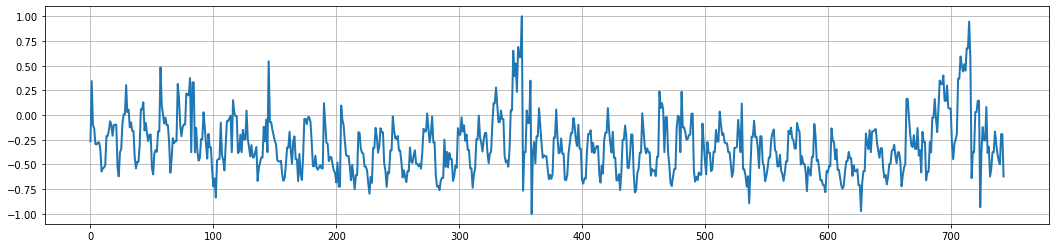

In [24]:
plt.plot(y_train)

# 모델 설계 및 훈련

- 모델 훈련에 사용될 환경 변수들은 store_online/online_definition.py 파일 내에 정의되어 있으니 원하는 경우 이를 수정하고 실행하면 된다.
- python 파일에서 직접 실행하려고 하는 경우에는 store_online/train.py를 직접 실행하면 main( )가 실행된다.

## 공통 함수

### Train Epoch 상태 표시 함수

In [25]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (epoch + 1) != 1 and (epoch + 1) % 10 == 0:
            print(f'{epoch+1}')
        else:
            print('.', end='')

### 모델 훈련 결과 차트 표시하는 함수

In [26]:
def plot_learning_curves(loss, style='b.-', label='Train loss'):
    plt.plot(np.arange(len(loss)) + 0.5, loss, style, label=label)
    plt.axis([1, len(loss), 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [27]:
# 모델 훈련 결과와 평가 결과를 저장하기 위한 변수를 생성한다.
performance_dic = {}

### RNN 기반 모델 생성을 위한 클래스

In [28]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
# from store_online.online_define import *


class LSTMModelManager:
    SIMPLE_LSTM = 'simple_lstm'
    STACKED_LSTM = 'stacked_lstm'
    BIDIRECTIONAL_LSTM = 'bidirectional_lstm'
    SIMPLE_GRU_LSTM = 'simple_gru'

    def __init__(self):
        pass

    @staticmethod
    def get_lstm_model(type, window_size=WINDOW_SIZE,
                       unit_num=LSTM_UNIT_NUM,
                       learning_rate=0.01,
                       dropout_rate=DROPOUT_RATE):
        """
        모델을 종류에 따라 정의하고 compile 한 후 반환한다.
        """

        if type == LSTMModelManager.SIMPLE_LSTM:
            """ LSTM이 1단인 기본 모델 """
            model = Sequential()
            model.add(LSTM(units=unit_num,
                           activation='relu',
                           input_shape=(window_size, 1)))
            model.add(Dense(16))
            model.add(Dense(1))
            model.compile(optimizer='adam',
                          loss='mse')

        elif type == LSTMModelManager.STACKED_LSTM:
            """ LSTM이 2단인 모델 """
            model = Sequential()
            model.add(LSTM(units=unit_num,
                           return_sequences=True,
                           activation='relu',
                           input_shape=(window_size, 1)))
            model.add(LSTM(units=WINDOW_SIZE,
                           activation='relu'))
            model.add(Dense(16))
            model.add(Dense(1))
            model.compile(optimizer='adam',
                          loss='mse')

        elif type == LSTMModelManager.BIDIRECTIONAL_LSTM:
            """ LSTM이 2단인 모델 """
            model = Sequential()
            model.add(Bidirectional(LSTM(units=unit_num,
                                         activation='relu'),
                                    input_shape=(window_size, 1)))
            model.add(Dense(16))
            model.add(Dense(1))
            model.compile(optimizer='adam',
                          loss='mse')

        elif type == LSTMModelManager.SIMPLE_GRU_LSTM:
            """ GRU 모델 """
            model = Sequential()
            model.add(GRU(units=unit_num,
                          input_shape=(window_size, 1),
                          return_sequences=False))
            model.add(Activation('tanh'))
            model.add(Dropout(dropout_rate))
            model.add(Dense(1))
            model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

        else:
            return None

        print(model.summary())
        return model

## Single-layered LSTM 모델

In [29]:
model_lstm = LSTMModelManager.get_lstm_model(type=LSTMModelManager.SIMPLE_LSTM, 
                                             window_size=WINDOW_SIZE, 
                                             learning_rate=LEARNING_RATE, 
                                             dropout_rate=DROPOUT_RATE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 68,641
Trainable params: 68,641
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
history_lstm = model_lstm.fit(X1, y_train,
                    epochs=NUM_EPOCH, 
                    verbose=0, 
                    validation_data=(X2, y_test), 
                    batch_size=BATCH_SIZE, 
                    steps_per_epoch=5,
                    callbacks=[PrintDot()])

.........10
.........20
.........30
.........40
.........50


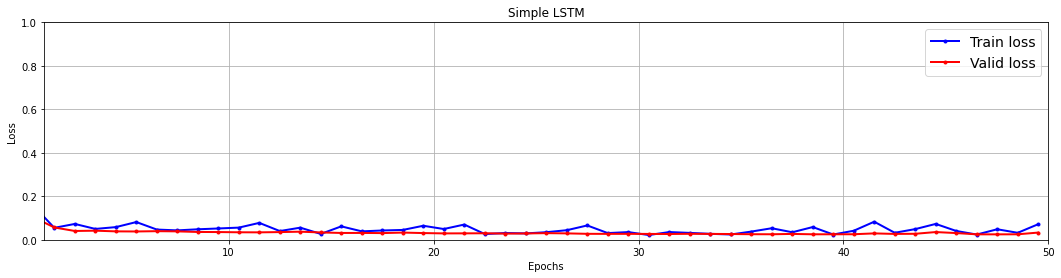

In [31]:
plt.title('Simple LSTM')
plot_learning_curves(history_lstm.history["loss"])
plot_learning_curves(history_lstm.history["val_loss"], 'r.-', 'Valid loss')
plt.show()

## Multi-layered LSTM 모델

In [32]:
model_stacked = LSTMModelManager.get_lstm_model(type=LSTMModelManager.STACKED_LSTM, 
                                                window_size=WINDOW_SIZE, 
                                                learning_rate=LEARNING_RATE, 
                                                dropout_rate=DROPOUT_RATE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 2680      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 69,353
Trainable params: 69,353
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
history_stacked = model_stacked.fit(X1, y_train,
                                    epochs=NUM_EPOCH, 
                                    verbose=0, 
                                    validation_data=(X2, y_test), 
                                    batch_size=BATCH_SIZE, 
                                    steps_per_epoch=5,
                                    callbacks=[PrintDot()]
                                    )

.........10
.........20
.........30
.........40
.........50


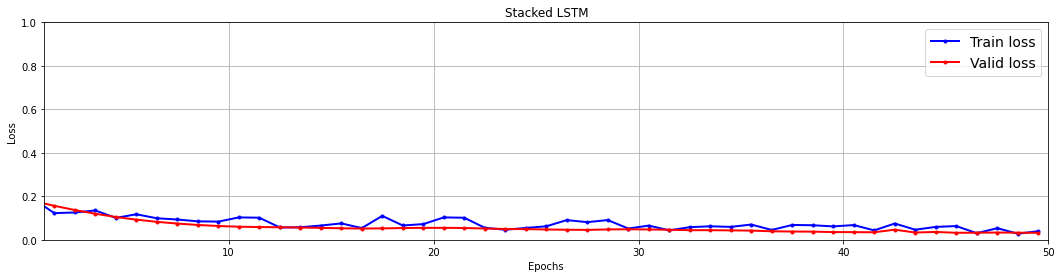

In [34]:
plt.title('Stacked LSTM')
plot_learning_curves(history_stacked.history["loss"])
plot_learning_curves(history_stacked.history["val_loss"], 'r.-', 'Valid loss')
plt.show()

## Bidirectional LSTM 모델

In [35]:
model_bidirectional = LSTMModelManager.get_lstm_model(type=LSTMModelManager.BIDIRECTIONAL_LSTM,
                                                      window_size=WINDOW_SIZE, 
                                                      learning_rate=LEARNING_RATE, 
                                                      dropout_rate=DROPOUT_RATE)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 137,249
Trainable params: 137,249
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
history_bidirectional = model_bidirectional.fit(X1, 
                                                y_train,
                                                epochs=NUM_EPOCH, 
                                                verbose=0, 
                                                validation_data=(X2, y_test), 
                                                batch_size=BATCH_SIZE, 
                                                steps_per_epoch=5,
                                                callbacks=[PrintDot()])

.........10
.........20
.........30
.........40
.........50


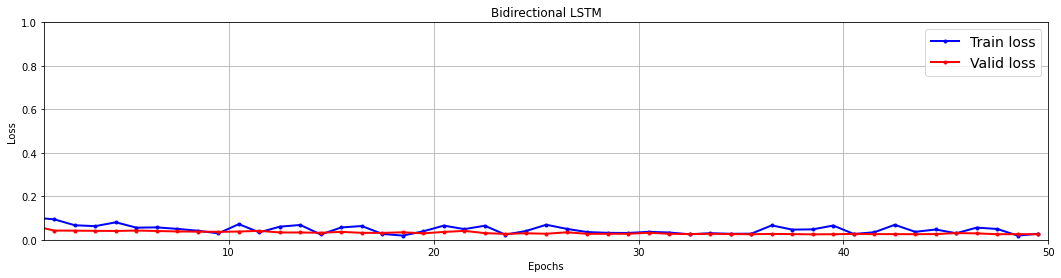

In [37]:
plt.title('Bidirectional LSTM')
plot_learning_curves(history_bidirectional.history["loss"])
plot_learning_curves(history_bidirectional.history["val_loss"], 'r.-', 'Valid loss')
plt.show()

## GRU model

In [38]:
model_gru = LSTMModelManager.get_lstm_model(type=LSTMModelManager.SIMPLE_GRU_LSTM, 
                                            window_size=WINDOW_SIZE, 
                                            learning_rate=LEARNING_RATE, 
                                            dropout_rate=DROPOUT_RATE)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history_gru = model_gru.fit(X1, y_train,
                            epochs=NUM_EPOCH, 
                            verbose=0, 
                            validation_data=(X2, y_test), 
                            batch_size=BATCH_SIZE, 
                            steps_per_epoch=5,
                            callbacks=[PrintDot()])

.........10
.........20
.........30
.........40
.........50


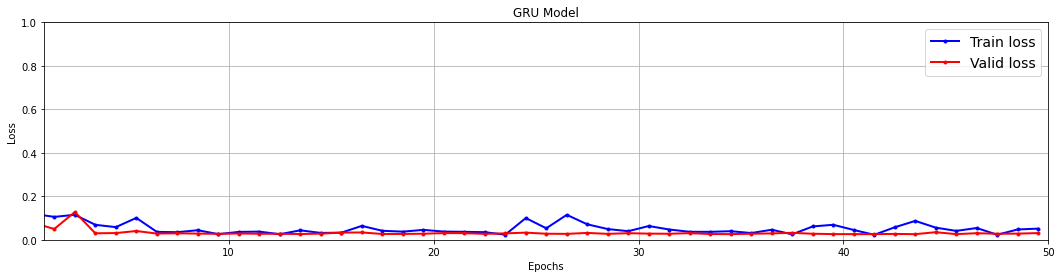

In [40]:
plt.title('GRU Model')
plot_learning_curves(history_gru.history["loss"])
plot_learning_curves(history_gru.history["val_loss"], 'r.-', 'Valid loss')
plt.show()

# 모델 테스트 및 평가

- 아래 inference 코드를 실행하면 준비된 데이터의 마지막 5일 데이터를 이용해 제품별로 판매량을 예측하여 출력한다.

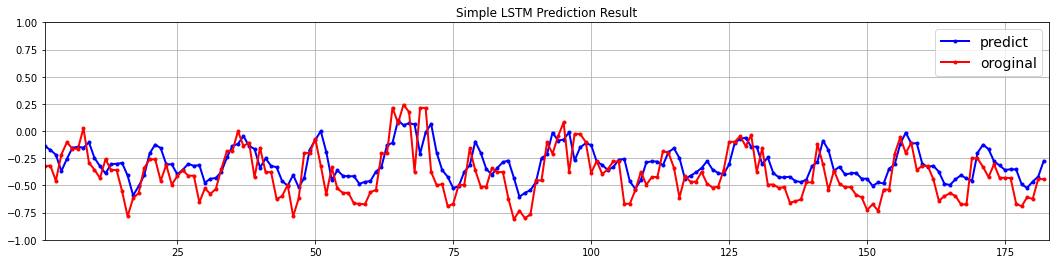

In [41]:
# Test 데이터에 대해 예측을 수행한다.
result_lstm = model_lstm.predict(X2)

plt.plot(result_lstm, 'b.-', label='predict')
plt.axis([1, len(result_lstm), -1, 1])
plt.legend(fontsize=14)

plt.plot(y_test, 'r.-', label='oroginal')
plt.axis([1, len(result_lstm), -1, 1])
plt.legend(fontsize=14)
plt.title('Simple LSTM Prediction Result')
plt.show()

In [42]:
performance_dic['simple LSTM'] = {'train': history_lstm.history["loss"][-1], 
                                  'valid': history_lstm.history["val_loss"][-1], 
                                  'eval': model_lstm.evaluate(X2, y_test, verbose=0)}

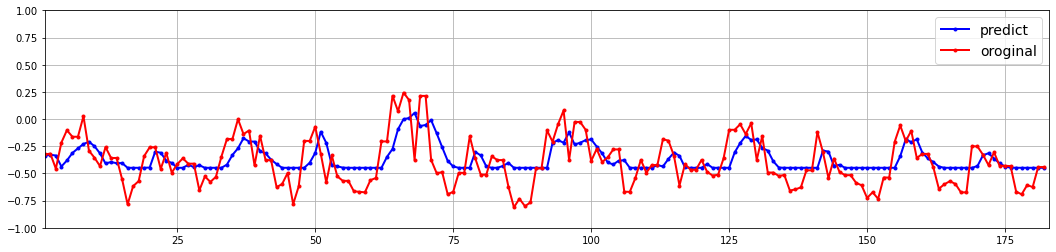

In [43]:
result_stacked = model_stacked.predict(X2)

plt.plot(result_stacked, 'b.-', label='predict')
plt.axis([1, len(result_stacked), -1, 1])
plt.legend(fontsize=14)

plt.plot(y_test, 'r.-', label='oroginal')
plt.axis([1, len(result_stacked), -1, 1])
plt.legend(fontsize=14)
plt.show()

In [44]:
performance_dic['stacked LSTM'] = {'train': history_stacked.history["loss"][-1], 
                                   'valid': history_stacked.history["val_loss"][-1], 
                                   'eval': model_stacked.evaluate(X2, y_test, verbose=0)}
performance_dic

{'simple LSTM': {'train': 0.07175019755959511,
  'valid': 0.03321447516562509,
  'eval': 0.03321447439206754},
 'stacked LSTM': {'train': 0.039450539462268355,
  'valid': 0.032165105994078305,
  'eval': 0.03216510658951405}}

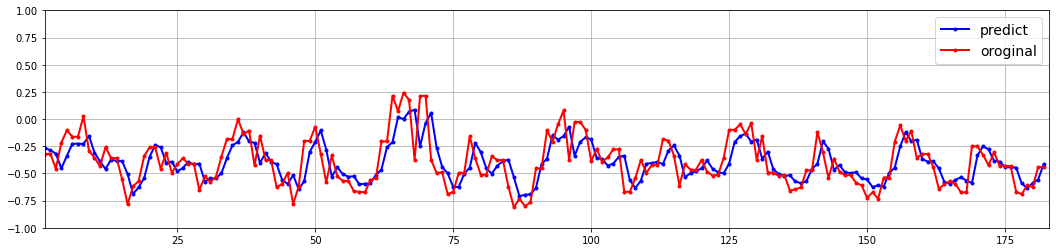

In [45]:
result_bidirectional = model_bidirectional.predict(X2)

plt.plot(result_bidirectional, 'b.-', label='predict')
plt.axis([1, len(result_bidirectional), -1, 1])
plt.legend(fontsize=14)

plt.plot(y_test, 'r.-', label='oroginal')
plt.axis([1, len(result_bidirectional), -1, 1])
plt.legend(fontsize=14)
plt.show()

In [46]:
performance_dic['bidirectional LSTM'] = {'train': history_bidirectional.history["loss"][-1], 
                                         'valid': history_bidirectional.history["val_loss"][-1], 
                                         'eval': model_bidirectional.evaluate(X2, y_test, verbose=0)}
performance_dic

{'simple LSTM': {'train': 0.07175019755959511,
  'valid': 0.03321447516562509,
  'eval': 0.03321447439206754},
 'stacked LSTM': {'train': 0.039450539462268355,
  'valid': 0.032165105994078305,
  'eval': 0.03216510658951405},
 'bidirectional LSTM': {'train': 0.02795698344707489,
  'valid': 0.02519393079949777,
  'eval': 0.02519393216085727}}

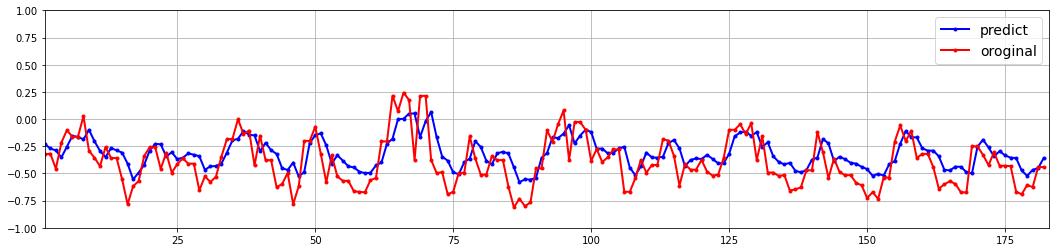

In [47]:
result_gru = model_gru.predict(X2)

plt.plot(result_gru, 'b.-', label='predict')
plt.axis([1, len(result_gru), -1, 1])
plt.legend(fontsize=14)

plt.plot(y_test, 'r.-', label='oroginal')
plt.axis([1, len(result_gru), -1, 1])
plt.legend(fontsize=14)
plt.show()

In [48]:
performance_dic['GRU LSTM'] = {'train': history_gru.history["loss"][-1], 
                                   'valid': history_gru.history["val_loss"][-1], 
                                   'eval': model_gru.evaluate(X2, y_test, verbose=0)}
performance_dic

{'simple LSTM': {'train': 0.07175019755959511,
  'valid': 0.03321447516562509,
  'eval': 0.03321447439206754},
 'stacked LSTM': {'train': 0.039450539462268355,
  'valid': 0.032165105994078305,
  'eval': 0.03216510658951405},
 'bidirectional LSTM': {'train': 0.02795698344707489,
  'valid': 0.02519393079949777,
  'eval': 0.02519393216085727},
 'GRU LSTM': {'train': 0.05134918726980686,
  'valid': 0.030906640237472097,
  'eval': 0.030906641407986806}}

**성능 정보 표시**

In [49]:
performance_df = pd.DataFrame.from_dict(performance_dic, orient='index')
print(list(performance_df.index))

performance_df

['simple LSTM', 'stacked LSTM', 'bidirectional LSTM', 'GRU LSTM']


,train,valid,eval
simple LSTM,0.071750,0.033214,0.033214
stacked LSTM,0.039451,0.032165,0.032165
bidirectional LSTM,0.027957,0.025194,0.025194
GRU LSTM,0.051349,0.030907,0.030907


Text(0.5, 1.0, 'Model Performance(loss)')

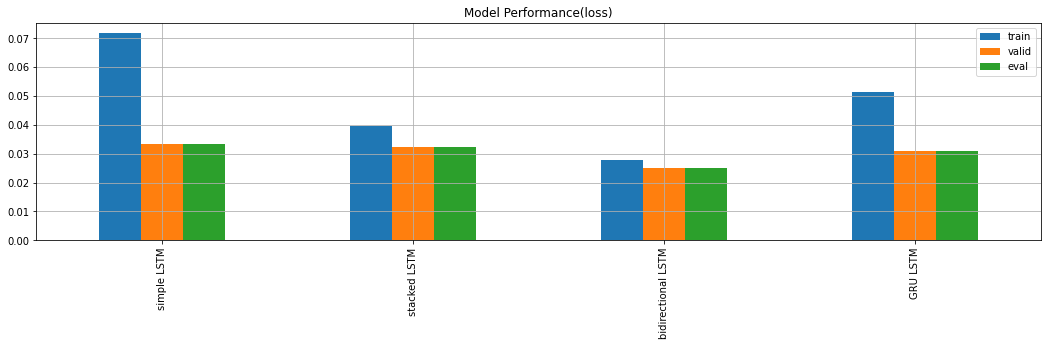

In [50]:
performance_df.plot.bar()
plt.title('Model Performance(loss)')

# 결과 리뷰 및 점검

- feature가 1개이기 때문에 데이터 자체가 매우 규칙적거나 패턴을 나타내거나 단기 미래를 예측할 때 활용될 수 있다.
- 여러 LSTM 모델을 통해 비교 적합한 모델을 한번에 훈련하고 상대 비교해 볼 수 있다.
- 단일 변수를 통한 예측이고, 최근 몇일 데이터로 단기간 미래를 예측하는 문제이기 때문에 moving average 된 것과 유사한 결과를 보여준다.
- 이는 장기간 주기성, 계절적 특징이나 이벤트 등 해당 변수 이외의 특징을 반영하지 못하는 한계를 나타낸다.

# 향후 개선 계획

- **window size**와 learning parameter를 조절해 가면서 최적의 성능을 확인할 수 있다.
- **LSTM 모델의 파라미터**, 즉 unit number, drop out rate, learning rate 등 파라미터 튜닝을 통해 성능을 개선할 수 있다.
- DL 모델의 Component를 추가, 혹은 삭제를 통해 여러개의 모델을 한 번에 실험하여 빠르게 적합한 모델을 선정하는데 활용할 수 있다.